# BIBLIOTECAS

In [35]:
# !pip install lifelines

In [36]:
from lifelines import KaplanMeierFitter,LogLogisticAFTFitter, WeibullAFTFitter, LogNormalAFTFitter # possui os métodos de estudo de sobrevivencia
from lifelines.statistics import multivariate_logrank_test

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# LEITURA ARQUIVO EQUIPAMENTOS

In [37]:
# arquivo contendo os dados mensurados de falha dos equipamentos

arquivo = pd.read_csv( 'comparacao.csv', sep= ';')

In [38]:
arquivo.head()

,DATA-INSTALACAO,DATA-RETIRADA,AREA-LOCAL,ANO-FAB,FALHOU?,TECNOLOGIA,MODELO
0,05/10/2011,14/11/2020,UB,2011,NAO FALHOU,ELETROMECANICO,A
1,11/04/2011,05/08/2020,UB,2011,NAO FALHOU,ELETROMECANICO,A
2,28/04/2016,30/07/2020,UB,2002,NAO FALHOU,ELETROMECANICO,A
3,26/04/2012,27/07/2020,UB,2012,NAO FALHOU,ELETROMECANICO,A
4,23/04/2012,13/07/2020,UB,2012,NAO FALHOU,ELETROMECANICO,A


- `DATA-INSTALACAO`: data em que o equipamento foi instalado
- `DATA-RETIRADA`: data em que o equipamento foi retirado
- `AREA-LOCAL`: local em que o equipamento estava instalado (URBANO ou RURAL)
- `ANO-FAB`: ano em que o equipamento foi fabricado
- `FALHOU?`: equipamento falhou ou não.
- `TECNOLOGIA`: tipo do equipamento. ELETRONICO ou ELETROMECANICO
- `MODELO`: modelo ficticio do equipamento

# TRANSFORMAÇÃO

### Transformação do dataframe

- corrigir Datas e a VIDA-UTIL do equipamento

In [39]:
# Verificar se há algum item faltante

arquivo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65386 entries, 0 to 65385
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DATA-INSTALACAO  65386 non-null  object
 1   DATA-RETIRADA    65386 non-null  object
 2   AREA-LOCAL       65386 non-null  object
 3   ANO-FAB          65386 non-null  int64 
 4   FALHOU?          65386 non-null  object
 5   TECNOLOGIA       65386 non-null  object
 6   MODELO           65386 non-null  object
dtypes: int64(1), object(6)
memory usage: 3.5+ MB


In [40]:
# obter quantos dias o equipamento permaneceu em operação

arquivo['DATA-RETIRADA'] = pd.to_datetime(arquivo['DATA-RETIRADA'],dayfirst = True)
arquivo['DATA-INSTALACAO'] = pd.to_datetime(arquivo['DATA-INSTALACAO'], dayfirst = True)

arquivo['VIDA-UTIL'] = (arquivo['DATA-RETIRADA']-arquivo['DATA-INSTALACAO'])/np.timedelta64(1,'D')

arquivo['VIDA-UTIL'] = arquivo['VIDA-UTIL']/365

In [41]:
# transformar os dados da coluna FALHOU? em numérico
# FALHA (FALHOU) = 1 / CENSURA (NAO FALHOU) = 0

arquivo['FALHOU?2'] = 1
arquivo.loc[arquivo['FALHOU?'] == 'NAO FALHOU', 'FALHOU?2'] = 0

### Teste LogRank

- serve para determinar quais variaveis são relevantes para o modelo através do `p-valor`

In [42]:
# usando metade dos dados como amostra

teste_log_rank = arquivo.sample(int(arquivo.shape[0]/2),random_state=1)
teste_log_rank.head()

,DATA-INSTALACAO,DATA-RETIRADA,AREA-LOCAL,ANO-FAB,FALHOU?,TECNOLOGIA,MODELO,VIDA-UTIL,FALHOU?2
22568,2012-02-13,2017-09-29,RR,2012,NAO FALHOU,ELETROMECANICO,A,5.630137,0
24489,2010-05-06,2017-05-30,UB,2010,NAO FALHOU,ELETROMECANICO,A,7.071233,0
10409,2015-07-23,2020-11-05,UB,2009,FALHOU,ELETROMECANICO,A,5.293151,1
20799,2011-08-08,2018-12-22,UB,2010,NAO FALHOU,ELETROMECANICO,A,7.378082,0
56682,2009-03-02,2017-10-17,UB,2003,NAO FALHOU,ELETROMECANICO,C,8.632877,0


In [43]:
itens = ['AREA-LOCAL','TECNOLOGIA','MODELO','ANO-FAB']

# verificar quais valores sao relevantes através do p-valor

for i in itens:
    print("TESTE LOGRANK PARA A COVARIAVEL:\n",i)
    result= multivariate_logrank_test(teste_log_rank['VIDA-UTIL'], teste_log_rank[i], teste_log_rank['FALHOU?2'])
    print(result.print_summary())
    print('\n')

TESTE LOGRANK PARA A COVARIAVEL:
 AREA-LOCAL


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.47 0.49      1.02

None


TESTE LOGRANK PARA A COVARIAVEL:
 TECNOLOGIA


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
        1500.59 <0.005       inf

None


TESTE LOGRANK PARA A COVARIAVEL:
 MODELO


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
        3812.71 <0.005       inf

None


TESTE LOGRANK PARA A COVARIAVEL:
 ANO-FAB


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 17
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
       15406.49 <0.005       inf

None




In [44]:
# Remover o item que ficou com p-valor > 0.05 - variavel nao é relevante

itens.remove('AREA-LOCAL')
itens

['TECNOLOGIA', 'MODELO', 'ANO-FAB']

### Modelo Referência

- Os métodos paramétricos/semi parametricos necessitam de um grupo de referência para a regressão. 
- Geralmente, nesses casos, buscamos identificar o item que mais dura em operação como 'baseline'

In [45]:
arquivo['Chave'] = arquivo['MODELO'] + '-' + arquivo['TECNOLOGIA'] + '-' + arquivo['ANO-FAB'].astype(str)
arquivo.head()

,DATA-INSTALACAO,DATA-RETIRADA,AREA-LOCAL,ANO-FAB,FALHOU?,TECNOLOGIA,MODELO,VIDA-UTIL,FALHOU?2,Chave
0,2011-10-05,2020-11-14,UB,2011,NAO FALHOU,ELETROMECANICO,A,9.117808,0,A-ELETROMECANICO-2011
1,2011-04-11,2020-08-05,UB,2011,NAO FALHOU,ELETROMECANICO,A,9.326027,0,A-ELETROMECANICO-2011
2,2016-04-28,2020-07-30,UB,2002,NAO FALHOU,ELETROMECANICO,A,4.257534,0,A-ELETROMECANICO-2002
3,2012-04-26,2020-07-27,UB,2012,NAO FALHOU,ELETROMECANICO,A,8.257534,0,A-ELETROMECANICO-2012
4,2012-04-23,2020-07-13,UB,2012,NAO FALHOU,ELETROMECANICO,A,8.227397,0,A-ELETROMECANICO-2012


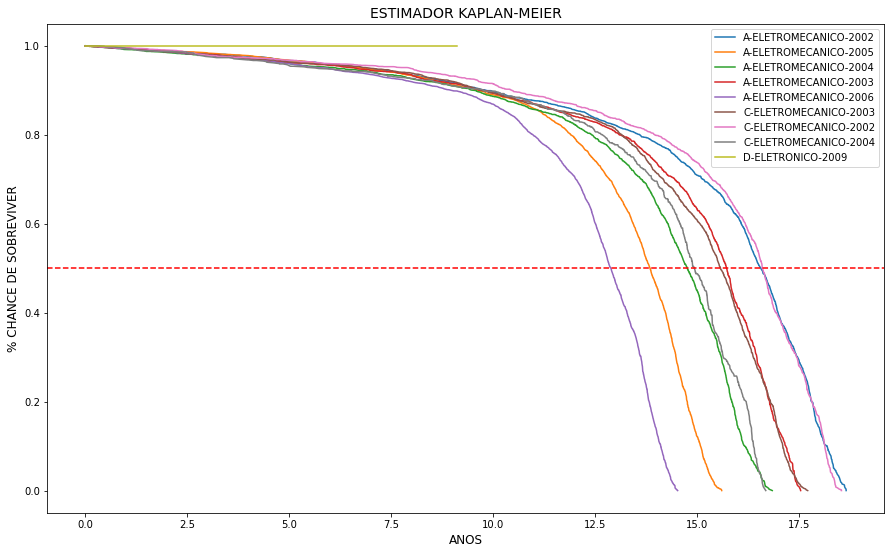

In [46]:
fig, axes = plt.subplots(1, 1, figsize=(15,9))
km_fitter = KaplanMeierFitter()
for i in arquivo['Chave'].unique():
    tempo = arquivo['VIDA-UTIL'].loc[arquivo['Chave'] == i]
    evento = arquivo['FALHOU?2'].loc[arquivo['Chave'] == i]
    
    km_fitter.fit(tempo, event_observed = evento, label = i)
    if km_fitter.median_survival_time_ > 12:
        km_fitter.survival_function_.plot(ax = axes)
        axes.set_title('ESTIMADOR KAPLAN-MEIER',fontsize = 14)
        axes.set_xlabel('ANOS', fontsize = 12)
        axes.set_ylabel('% CHANCE DE SOBREVIVER', fontsize = 12)
axes.axhline(0.5, color = 'red', linestyle = '--')
plt.show()

##### Referencia será o equipamento C, ELETROMECANICO de 2002

In [47]:
referencia = pd.DataFrame([['MODELO','C'],['TECNOLOGIA','ELETROMECANICO'],['ANO-FAB',2002]],
                          columns = ['CLASSE','ITEM'])
referencia

,CLASSE,ITEM
0,MODELO,C
1,TECNOLOGIA,ELETROMECANICO
2,ANO-FAB,2002


### Criação das variaveis "dummies"

- necessário transformar em numérico para a regressão
- semelhante ao tratamento do OneHotEncoder()

In [48]:
dummies = arquivo.copy()

for i,item in enumerate(referencia['CLASSE'].unique()):
    dummies[item].loc[dummies[item] == referencia['ITEM'][i]] = 0

dummies.sort_values(by=['MODELO','ANO-FAB','TECNOLOGIA'],ascending=[True,True,True], inplace=True)
dummies.head()

C:\Users\pedro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\pedro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,DATA-INSTALACAO,DATA-RETIRADA,AREA-LOCAL,ANO-FAB,FALHOU?,TECNOLOGIA,MODELO,VIDA-UTIL,FALHOU?2,Chave
51769,2002-04-24,2020-09-03,UB,0,FALHOU,0,0,18.375342,1,C-ELETROMECANICO-2002
51771,2003-06-07,2019-04-11,UB,0,FALHOU,0,0,15.854795,1,C-ELETROMECANICO-2002
51777,2002-11-29,2019-05-29,UB,0,NAO FALHOU,0,0,16.506849,0,C-ELETROMECANICO-2002
51778,2004-01-21,2020-08-03,UB,0,FALHOU,0,0,16.545205,1,C-ELETROMECANICO-2002
51779,2018-04-30,2018-05-28,UB,0,FALHOU,0,0,0.076712,1,C-ELETROMECANICO-2002


In [49]:
# colunas desnecessárias
dummies.drop(['FALHOU?','Chave','DATA-INSTALACAO','DATA-RETIRADA','AREA-LOCAL'],axis=1,inplace=True)

#"dummificação"
dummies = pd.get_dummies(dummies,columns = ['MODELO','ANO-FAB','TECNOLOGIA'],drop_first = True)

dummies.head()

,VIDA-UTIL,FALHOU?2,MODELO_A,MODELO_B,MODELO_D,ANO-FAB_2003,ANO-FAB_2004,ANO-FAB_2005,ANO-FAB_2006,ANO-FAB_2007,ANO-FAB_2008,ANO-FAB_2009,ANO-FAB_2010,ANO-FAB_2011,ANO-FAB_2012,ANO-FAB_2013,ANO-FAB_2014,ANO-FAB_2015,ANO-FAB_2016,ANO-FAB_2017,ANO-FAB_2018,ANO-FAB_2019,TECNOLOGIA_ELETRONICO
51769,18.375342,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51771,15.854795,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51777,16.506849,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51778,16.545205,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51779,0.076712,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Modelo de Vida Acelerado

- Aqui será feito o 'fit' do modelo;
- Com os dados do print_summary(), remove-se os itens com p-valor > 0.05 e realiza novamente o fit;
- Após o fit definitivo, obtem-se os parametros que melhor se encaixam no modelo
- Este modelo basicamente estima a taxa de degradação/sobrevivência entre as populações estudadas

In [50]:
arquivo.loc[arquivo['VIDA-UTIL']<0]

,DATA-INSTALACAO,DATA-RETIRADA,AREA-LOCAL,ANO-FAB,FALHOU?,TECNOLOGIA,MODELO,VIDA-UTIL,FALHOU?2,Chave


In [51]:
# primeiro, buscamos o que melhor entrega o fit dos dados entre os tipos de estimadores

logistic_fitter = LogLogisticAFTFitter().fit(dummies, 'VIDA-UTIL', 'FALHOU?2')
log_fitter = LogNormalAFTFitter().fit(dummies, 'VIDA-UTIL', 'FALHOU?2')
weibull_fitter = WeibullAFTFitter().fit(dummies, 'VIDA-UTIL', 'FALHOU?2')

print(logistic_fitter.AIC_)  # 194585
print(log_fitter.AIC_)  # 216544
print(weibull_fitter.AIC_)   # 184595. Weibull é o melhor

C:\Users\pedro\anaconda3\lib\site-packages\lifelines\fitters\__init__.py:2049: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with LogNormalAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)


194585.11411748012
216544.9980146619
184595.43394535652


C:\Users\pedro\anaconda3\lib\site-packages\lifelines\fitters\__init__.py:2049: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)


In [53]:
wf = WeibullAFTFitter(penalizer = 0.05).fit(dummies, 'VIDA-UTIL', 'FALHOU?2')
wf.print_summary()

<lifelines.WeibullAFTFitter: fitted with 65386 total observations, 35091 right-censored observations>
             duration col = 'VIDA-UTIL'
                event col = 'FALHOU?2'
                penalizer = 0.05
   number of observations = 65386
number of events observed = 30295
           log-likelihood = -96295.70
         time fit was run = 2021-05-23 20:11:12 UTC

---
                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                     
lambda_ ANO-FAB_2003           -0.03       0.97       0.01            -0.05            -0.02                 0.96                 0.98
        ANO-FAB_2004           -0.08       0.92       0.01            -0.10            -0.07                 0.91                 0.93
        ANO-FAB_2005           -0.14       0.87       0.01            -0.15            -0.13                 0.86                 0.88
        ANO-FAB_2006           -0.21       0.81       0.01            -0.22            -0.19                 0.80                 0.82
        ANO-FAB_2007           -0.28       0.75       0.01            -0.30            -0.27                 0.74                 0.76
        ANO-FAB_2008           -0.36       0.70       0.01            -0.37            -0.34                 0.69                 0.71
        ANO-FAB_2009           -0.43       0.65       0.01            -0.44            -0.41                 0.64                 0.66
        ANO-FAB_2010           -0.52       0.60       0.01            -0.53            -0.50                 0.59                 0.60
        ANO-FAB_2011           -0.63       0.53       0.01            -0.64            -0.61                 0.53                 0.54
        ANO-FAB_2012           -0.68       0.51       0.01            -0.70            -0.66                 0.50                 0.52
        ANO-FAB_2013           -0.87       0.42       0.02            -0.90            -0.84                 0.41                 0.43
        ANO-FAB_2014           -0.82       0.44       0.03            -0.87            -0.77                 0.42                 0.46
        ANO-FAB_2015           -0.98       0.38       0.02            -1.02            -0.93                 0.36                 0.39
        ANO-FAB_2016           -1.07       0.34       0.03            -1.12            -1.02                 0.33                 0.36
        ANO-FAB_2017           -1.53       0.22       0.15            -1.82            -1.24                 0.16                 0.29
        ANO-FAB_2018           -1.71       0.18       0.18            -2.07            -1.36                 0.13                 0.26
        ANO-FAB_2019           -2.53       0.08       0.11            -2.75            -2.30                 0.06                 0.10
        MODELO_A               -0.01       0.99       0.01            -0.03            -0.00                 0.98                 1.00
        MODELO_B                0.16       1.18       0.03             0.10             0.23                 1.10                 1.26
        MODELO_D               -0.17       0.84       0.03            -0.24            -0.10                 0.79                 0.90
        TECNOLOGIA_ELETRONICO  -0.06       0.94       0.03            -0.13             0.00                 0.88                 1.00
        Intercept               2.84      17.03       0.01             2.82             2.85                16.86                17.21
rho_    Intercept               1.41       4.11       0.01             1.40             1.42                 4.07                 4.15

                                   z      p   -log2(p)
param   covariate                                     
lambda_ ANO-FAB_2003           -5.50 <0.005      24.66
        ANO-FAB_2004          -12.13 <0.005     110.08
        ANO-FAB_2005       

In [82]:
# parametros relevantes do Cox (coluna indice com as colunas das 'dummies' que melhor encaixam no modelo)

parametros = pd.DataFrame(wf.params_)
parametros.columns = ['valor']
parametros['tipo'] = parametros.index.get_level_values(0)
parametros['classe'] = parametros.index.get_level_values(1)
parametros.reset_index(drop = True, inplace = True)
parametros = parametros.loc[parametros['classe'] != 'Intercept','classe'].values.tolist()

In [83]:
parametros

['ANO-FAB_2003',
 'ANO-FAB_2004',
 'ANO-FAB_2005',
 'ANO-FAB_2006',
 'ANO-FAB_2007',
 'ANO-FAB_2008',
 'ANO-FAB_2009',
 'ANO-FAB_2010',
 'ANO-FAB_2011',
 'ANO-FAB_2012',
 'ANO-FAB_2013',
 'ANO-FAB_2014',
 'ANO-FAB_2015',
 'ANO-FAB_2016',
 'ANO-FAB_2017',
 'ANO-FAB_2018',
 'ANO-FAB_2019',
 'MODELO_A',
 'MODELO_B',
 'MODELO_D',
 'TECNOLOGIA_ELETRONICO']

# Predição Cox

- para a predição, os valores devem estar filtrados pelos parâmetros que o Cox entregou;
- Além disso, o dataframe deve estar no formato de "dummies", como repassamos anteriormente

In [86]:
# amostra aleatoria de 10 itens

teste = dummies.sample(10)
teste = teste[parametros]

# predição
wf.predict_expectation(teste)

9494     15.242423
2805      8.153841
27376     9.079438
62758     4.614334
17275    14.737364
37317    10.680697
48536    10.182832
631       9.079438
48509     9.144750
21547     9.079438
dtype: float64

In [87]:
wf.predict_survival_function(teste)

,9494,2805,27376,62758,17275,37317,48536,631,48509,21547
0.002740,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.005479,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.008219,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.010959,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.013699,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...
18.605479,0.217531,2.095552e-09,0.000003,6.213102e-91,0.173403,0.001381,0.000331,0.000003,0.000004,0.000003
18.619178,0.216528,1.972383e-09,0.000003,3.310322e-91,0.172485,0.001354,0.000323,0.000003,0.000004,0.000003
18.632877,0.215527,1.856195e-09,0.000002,1.761185e-91,0.171569,0.001327,0.000315,0.000002,0.000004,0.000002
18.641096,0.214927,1.789675e-09,0.000002,1.205215e-91,0.171021,0.001311,0.000311,0.000002,0.000003,0.000002


In [88]:
# Curva ROC
wf.concordance_index_

0.7604900223327757

In [134]:
# para mais detalhes, consulte:
# https://lifelines.readthedocs.io/en/latest/fitters/regression/CoxPHFitter.html